In [2]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from interaction_permutation_importance import *
import matplotlib.pyplot as plt

def gen_X(num_var: int, sample_size : int):
    data_dictionary = {}
    for i in range(num_var):
        var_name = "x" + f"{i + 1}"
        data_dictionary[var_name] = list(np.random.binomial(1, .5, sample_size))
    return pd.DataFrame(data_dictionary)

sys.path.append('/root/barcode/')
from BarcodeScanner import tree_and_clustering, base_barcode
from importance_score import f_test_result
import scipy
from scipy.stats import f
from sklearn.base import BaseEstimator, clone
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics      import r2_score

import numpy as np; import pandas as pd
from typing import List, Union

# itertools
from itertools import combinations

from utils import *

class one_way_ANOVA(BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, df, response_var_name =None):
        if response_var_name:
            try:
                df[response_var_name]
                self.response_var_name = response_var_name
            except:
                self.response_var_name = df.columns.tolist()[-1]
        else:
            self.response_var_name = df.columns.tolist()[-1]
        self.independet_var_name = df.columns[~df.columns.str.contains(self.response_var_name)].tolist()
        self.segment_means = df.groupby(self.independet_var_name)[self.response_var_name].mean().reset_index()
        self.segment_means.columns= self.segment_means.columns.tolist()[:-1] + ['y_hat']
        output = df.merge(self.segment_means, how = 'left', on = self.independet_var_name)
        y = output[self.response_var_name].to_numpy().reshape(-1)
        y_pred = output['y_hat'].to_numpy().reshape(-1)
        self._rsq = r2_score(y, y_pred)
        self.sse  = np.square(y - y_pred).sum()
        self.MSE_ = self.sse/(y.shape[0])
        output['sq'] = (output.y_hat - output[self.response_var_name])**2
        summary = output.groupby(self.independet_var_name).agg({"y_hat": np.mean, "sq": [lambda x: x.sum()/x.count(), 'count']}).reset_index()
        summary.columns = self.independet_var_name + ['group_means','mse','count']
        self._summary_table = summary
        return self
    

    @property
    def score(self):
        if hasattr(self, '_rsq'):
            return self._rsq
        else:
            raise AttributeError("fit the estimator first")
    
    @property
    def MSE(self):
        if hasattr(self, "MSE_"):
            return self.MSE_
        else:
            raise AttributeError("fit the estimator first")
class anova_clustering(base_barcode):
    def __init__(self, X, y):
        super().__init__(X, y)
        self.clean_data()
        self.estimator = one_way_ANOVA()
        self.fit()

    def clean_data(self):
        full_df = self.X.copy()
        full_df['y'] = self.y.reshape(-1)
        sorted_index = full_df.sort_values(full_df.columns.tolist()[:-1]).index.tolist()
        self.full_df = full_df.loc[sorted_index, :].reset_index(drop = True)
        self.barcode_df = pd.DataFrame(zip(self.barcode.reshape(-1), self.y.reshape(-1)), columns = ['z','y']).loc[sorted_index, :].reset_index(drop = True)
        self.X = full_df.iloc[:, :-1]
        self.y = full_df.y.to_numpy().reshape(-1,1);
        self.num_full_var = 2**self.X.shape[1]
        self.num_main_var = self.X.shape[1]
        del sorted_index
        del full_df
        
    def fit(self):   
        self.estimator.fit(self.full_df)
        self._summary_table = self.estimator._summary_table
        self._fit = True

    def gen_clustering_summary_table(self, num_clusters):
        original_summary = self.summary_table.copy()
        original_summary = original_summary.drop(['group_means','mse', 'count'], axis = 1)
        original_summary['y_pred'] = self.get_projected_mu_hat(num_clusters)
        full_df = self.full_df.copy()
        full_df = full_df.merge(original_summary, on = self.estimator.independet_var_name, how = 'left')
        return full_df
    
    def metric_after_clustering(self, num_clusters, metric = r2_score):
        full_df = self.gen_clustering_summary_table(num_clusters)
        return metric(full_df.y, full_df.y_pred)



    @property
    def summary_table(self):
        if hasattr(self, "_summary_table"):
            pass
        else:
            self._summary_table = self.predict_from_training()
        return self._summary_table
    
    @property
    def init_mu_hat(self):
        if hasattr(self, "_init_mu_hat"):
            pass
        else:
            self._init_mu_hat = self.summary_table.group_means.tolist()
            self._init_mu_hat = np.array(self._init_mu_hat).reshape(-1)
        return self._init_mu_hat
    
    @property
    def init_mu_var(self):
        if hasattr(self, "_init_mu_var"):
            pass
        else:
            self._init_mu_var = np.diag(self.summary_table.mse/self.summary_table['count'])
        return self._init_mu_var
    
    @property
    def init_beta_hat(self):
        if hasattr(self, "_init_beta_hat"):
            pass
        else:
            self._init_beta_hat = self.L_inv @ self.init_mu_hat
        return self._init_beta_hat

    @property
    def init_beta_var(self):
        if hasattr(self, "_init_beta_var"):
            pass
        else:
            self._init_beta_var = self.L_inv @ self.init_mu_var @ self.L_inv.T
        return self._init_beta_var

    @property
    def clustering_init_kwargs(self):
        summary = self.summary_table
        kwargs = {"means": summary.group_means.tolist(), "variances": summary.mse.tolist(), "sample_sizes": summary['count'].tolist()}
        return kwargs
    
    @property
    def init_cluster_idx(self):
        if hasattr(self, "_init_cluster_idx"):
            pass
        else:
            sample_sizes = self.clustering_init_kwargs['sample_sizes']
            clusters = []
            last = 0
            for n in sample_sizes:
                clusters.append([x for x in range(last, n+last)])
                last += n
            self._init_cluster_idx = clusters
        return self._init_cluster_idx

    @property
    def init_pdist(self):
        if hasattr(self, "_init_pdist"):
            pass
        else:
            self._init_pdist = self.pairwise_distances_from_means_variances(**self.clustering_init_kwargs)
        return self._init_pdist

    def cluster(self, n_clusters, save = True):
        self.last_n_clusters = n_clusters
        pdist = self.init_pdist.copy()
        init_cluster_idx = self.init_cluster_idx.copy()
        result = self.agglomerative_clustering(pairwise_distances = pdist, n_clusters = n_clusters, clusters = init_cluster_idx)
        cluster_idx = result[0]
        final_pdist = result[1]
        cluster_df = {}
        for cluster_id, cluster_index in enumerate(cluster_idx):
            cluster_id_name = f"cluster_{cluster_id}"
            cluster_df[cluster_id_name] = self.full_df.loc[cluster_index,:].copy()
            cluster_df[cluster_id_name] = cluster_df[cluster_id_name].groupby(self.original_columns).agg(np.mean).reset_index()
            cluster_df[cluster_id_name]['barcode'] = self.gen_barcode((cluster_df[cluster_id_name].loc[:, self.original_columns]))
        if save:
            self._latest_cluster_dfs = cluster_df
        else:
            self._latest_cluster_dfs = None
        
        return {"cluster": cluster_df, "final_pdist": final_pdist}

    def gen_mu_contrast_from_cluster(self, n_clusters, use_latest_cluster_df = True):
        if use_latest_cluster_df:
            if hasattr(self, '_latest_cluster_dfs'):
                if (self._latest_cluster_dfs != None) & (self.last_n_clusters == n_clusters):
                    cluster_df_list = self._latest_cluster_dfs
        try:
            cluster_df_list
        except:
            cluster_result = self.cluster(n_clusters = n_clusters)
            cluster_df_list = cluster_result['cluster']
            
        contrast_matrix = 0
        for cluster_name, cluster_df in cluster_df_list.items():
            if cluster_df.shape[0] > 1:
                contrast = np.zeros((cluster_df.shape[0]-1, 2**len(self.original_columns)))
                for i, row in enumerate(contrast):
                    row[cluster_df.barcode[0]] = 1
                    row[cluster_df.barcode[i+1]] = -1
                    contrast[i] = row
                if isinstance(contrast_matrix, np.ndarray):
                    contrast_matrix = np.concatenate([contrast_matrix, contrast], axis = 0)
                else:
                    contrast_matrix = contrast
            else:
                pass
        return contrast_matrix
    
    def gen_projection_matrix_mu(self, n_clusters):
        C = self.gen_mu_contrast_from_cluster(n_clusters)
        projection_matrix = C.T @ np.linalg.inv(C @ C.T) @ C
        projection_matrix = np.identity(C.shape[1]) - projection_matrix
        return projection_matrix
    
    def get_projected_mu_hat(self, n_clusters):
        mu = self.init_mu_hat
        proj_mu = self.gen_projection_matrix_mu(n_clusters = n_clusters) @ mu
        return proj_mu
    
    def get_projected_mu_hat_var(self, n_clusters):
        mu_var = self.init_mu_var
        proj = self.gen_projection_matrix_mu(n_clusters = n_clusters)
        proj_mu_var = proj @ mu_var @ proj.T
        return proj_mu_var
    
    def get_projected_beta_hat(self, n_clusters):
        proj_mu = self.get_projected_mu_hat(n_clusters = n_clusters)
        proj_beta = self.L_inv @ proj_mu
        return proj_beta
    
    def get_projected_beta_hat_var(self, n_clusters):
        mu_var = self.get_projected_mu_hat_var(n_clusters)
        return self.L_inv @ mu_var @ self.L_inv.T

    
    def ward_linkage(self, pairwise_distances, clusters, merge_indices):
        clusters = clusters.copy()
        i, j = merge_indices
        cluster_i = clusters[i]
        cluster_j = clusters[j]
        n_i = len(cluster_i)
        n_j = len(cluster_j)
        n = pairwise_distances.shape[1]
        new_distances = pairwise_distances.copy()
        new_distances = np.delete(new_distances, merge_indices, axis = 0)
        new_distances = np.delete(new_distances, merge_indices, axis = 1)
        new_distances = np.append(new_distances, np.zeros((1, new_distances.shape[1])), axis = 0)
        new_distances = np.append(new_distances,  np.zeros((new_distances.shape[0], 1)), axis = 1)
        clusters.append(cluster_i + cluster_j)
        clusters.remove(cluster_i)
        clusters.remove(cluster_j)
        col = 0
        
        for k in range(n):  # Subtract 2 because we've already added a row and column
            if k != i and k != j:
                n_k = len(clusters[col])
                n_all = n_i + n_j + n_k
                dist_ik = pairwise_distances[i, k]*(n_k + n_i)/n_all
                dist_jk = pairwise_distances[j, k]*(n_j + n_k)/n_all
                dist_ij = pairwise_distances[i, j]*(n_k)/n_all
                new_dist = dist_ik + dist_jk - dist_ij
                # Add other linkage methods here if needed
                
                new_distances[-1, col] = new_dist
                new_distances[col, -1] = new_dist
                col += 1

        return new_distances, clusters
    
    def gen_reduced_clustering(self, n_clusters):
        return self.agglomerative_clustering(pairwise_distances= self.init_pdist, n_clusters = n_clusters)

    def agglomerative_clustering(self, pairwise_distances, n_clusters, clusters = None, estimator = None):
        n = pairwise_distances.shape[0]
        if clusters:
            pass
        else:
            clusters = [[i] for i in range(n)]
        
        assert len(clusters) == n
        
        for k in range(n - n_clusters):
            min_dist = np.inf
            merge_indices = None
            
            for i in range(len(clusters)):
                for j in range(i + 1, len(clusters)):
                    dist = pairwise_distances[i, j]
                    if dist < min_dist:
                        min_dist = dist
                        merge_indices = (i, j)
            
            if merge_indices:
                pairwise_distances, clusters = self.ward_linkage(pairwise_distances, clusters, merge_indices)
        
        return clusters, pairwise_distances
    
    def pairwise_distances_from_means_variances(self, means, variances, sample_sizes):
        num_clusters = len(means)
        pairwise_distances = np.zeros((num_clusters, num_clusters))
        
        for i in range(num_clusters):
            for j in range(i + 1, num_clusters):
                n_i = sample_sizes[i]
                n_j = sample_sizes[j]
                mean_i = means[i]
                mean_j = means[j]
                var_i = variances[i]
                var_j = variances[j]
                
                # Calculate the pairwise distance using Ward linkage formula
                numerator = (n_i * n_j / (n_i + n_j)) * (mean_i - mean_j)**2
                denominator = np.sqrt((n_i * var_i + n_j * var_j) / (n_i + n_j))
                
                pairwise_distances[i, j] = np.sqrt(numerator / denominator)
                pairwise_distances[j, i] = pairwise_distances[i, j]
        
        return pairwise_distances

    def contrast_generator(self, max_variables = None):
        from itertools import product
        from scipy.sparse import vstack
        all_interaction_betas = scipy.sparse.eye(self.num_full_var - self.num_main_var -1, self.num_full_var, k = self.num_main_var + 1)
        betas_in_test = product([False, True], repeat = self.num_full_var - self.num_main_var -1)
        
        def get_new_contrasts(beta):
            vstacks = []
            for i, b in enumerate(beta):
                if b:
                    vstacks.append(all_interaction_betas.getrow(i))
            return vstack(vstacks).astype(np.uint8)
        if max_variables is not None:
            for beta in betas_in_test:
                if sum(beta) and (sum(beta) <= max_variables):
                    yield get_new_contrasts(beta)
        else:
            for beta in betas_in_test:
                if sum(beta):
                    yield get_new_contrasts(beta)


    @staticmethod    
    def partial_f_test(contrast, L_inv, cell_means, cell_means_covariance, sample_size):
        assert contrast.shape[0] < contrast.shape[1]
        assert contrast.shape[1] == L_inv.shape[0]
        assert L_inv.shape[0] == L_inv.shape[1]
        assert cell_means_covariance.shape == L_inv.shape
        from numpy.linalg import inv
        nu_1 = contrast.shape[0]
        nu_2 = sample_size - L_inv.shape[0]
        contrast = contrast.toarray()

        LC = contrast @ L_inv.T
        mu = LC @ cell_means
        var = LC @ cell_means_covariance @ LC.T
        try:
            f_value = mu.T @ inv(var) @ mu
            f_value /= nu_1
        except:
            f_value = 0
        
        return f_test_result(nu_1, nu_2, f_value)
    
    def gen_importance_score(self, num_clusters, filename = 'importance_score.csv', dir = os.getcwd(), max_variables = None):
        cell_means = self.get_projected_mu_hat(num_clusters)
        covariance = self.get_projected_mu_hat_var(num_clusters)
        kwargs = {"L_inv": self.L_inv, "cell_means": cell_means, "cell_means_covariance": covariance, "sample_size": self.X.shape[0]}

        from csv import writer
        from tqdm import tqdm
        with open(os.path.join(dir, filename), 'w') as f:
            csv_writer = writer(f)
            csv_writer.writerow(self.beta_names + ['score'])
            contrasts =  self.contrast_generator(max_variables = max_variables)
            from math import comb
            if max_variables:
                total_iter = sum([comb(self.num_full_var - self.num_main_var -1, x) for x in range(1, max_variables +1)])
            else:
                total_iter = sum([comb(self.num_full_var - self.num_main_var -1, x) for x in range(1,self.num_full_var - self.num_main_var)])
            for contrast in tqdm(contrasts, total = total_iter):
                result = self.partial_f_test(contrast = contrast, **kwargs)
                score = result.cdf
                row = contrast.sum(axis = 0).tolist()[0] + [score]
                csv_writer.writerow(row)
            else:
                from joblib import Parallel, delayed
                num_cores = os.cpu_count()
                batch_size = 1000 * num_cores
                partition_size = 1000
                contrast_batch = []
                for i, contrast in tqdm(enumerate(contrasts), total = total_iter):
                    contrast_batch.append(contrast)
                    if len(contrast_batch) % batch_size == 0:
                        f_test_results = Parallel(n_jobs=num_cores)(delayed(self.partial_f_test)(c, **kwargs) for c in contrast_batch)
                        f_test_results = [x.cdf for x in f_test_results]
                        rows = [c.sum(axis = 0).tolist()[0] + [f] for c,f in zip(contrast_batch, f_test_results)]
                        csv_writer.writerows(rows)
                        del contrast_batch
                        del rows
                        del f_test_results
                        contrast_batch = []
                # process the remainder
                if len(contrast_batch):
                    f_test_results = Parallel(n_jobs=num_cores)(delayed(self.partial_f_test)(c, **kwargs) for c in contrast_batch)
                    f_test_results = [x.cdf for x in f_test_results]
                    rows = [c.sum(axis = 0).tolist()[0] + [f] for c,f in zip(contrast_batch, f_test_results)]
                    csv_writer.writerows(rows)

from glob import glob
import pandas as pd
from dask import dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import joblib
@dataclass
class f_test_result:
    nu_1:int
    nu_2:int
    f_statistic: float
    
    @property
    def p_value(self):
        if hasattr(self, '_p_value'):
            pass
        else:
            sdf = f.sf(self.f_statistic, self.nu_1, self.nu_2, loc=0, scale=1)
            self._p_value = sdf
        return self._p_value
    
    @property
    def cdf(self):
        if hasattr(self, '_cdf'):
            pass
        else:
            self._cdf = 1 - self.p_value
        return self._cdf
from math import sqrt


In [1]:
def main_effect_eq(seq):
    return 1 + seq.x1 + seq.x2+ seq.x3 + seq.x4 + seq.x5

# Goal of this simulation

* confidence interval of $\hat{\tau}$ from bootstrap
    * Compare whether this is difference between hirarchical and non-hirarchical model equation
    * As the dimension of model increases, does $\tau$ also increases?
    * What is the relationship of $\tau$ with sample size and error?
    

#### When $p*$ is 6

hiarchical : $y = 1 + x_1 + x_2 + x_3 + x_1 x_2 + x_1 x_3$

In [118]:
def gen_y(seq, error_var = 2):
    y = 1 + seq.x1 + seq.x2 + seq.x3 + seq.x1 * seq.x2 + seq.x1 * seq.x3 
    y += np.random.normal(scale = sqrt(error_var))
    return y

In [119]:
from tqdm import tqdm

def bootstrap(gen_y_func, iter = 100, sample_size = 500):
    tables = []
    for i in tqdm(range(iter)):
        X = gen_X(5, sample_size)
        y = X.apply(gen_y, axis = 1)
        y.name = 'y'
        df = pd.concat([X, y], axis = 1)
        clustering = anova_clustering(df.iloc[:, :-1], df.y)
        tau_estimates = []
        tau_estimates_lb = []
        num_clusters = list(range(2, 2**5))
        for k in num_clusters:
            tau_est = tau(df.shape[0], 2**5, k, clustering.estimator.score, clustering.metric_after_clustering(num_clusters = k))
            tau_estimates.append(tau_est.tau_est)
            tau_estimates_lb.append(tau_est.tau_LB)
        tau_output = pd.DataFrame(zip(num_clusters, tau_estimates, tau_estimates_lb), columns = ['num_clusters','tau_estimates','tau_estimate_lower_bound'])
        tau_output['iteration'] = i
        tables.append(tau_output)

    return tables

In [120]:
tables = bootstrap(gen_y)

100%|██████████| 100/100 [02:43<00:00,  1.63s/it]


In [121]:
def confidence_intervals(tables, num_clusters):
    df = pd.concat(tables,axis = 0).reset_index(drop = True)
    summary = df.groupby('num_clusters').agg({'tau_estimates': ["mean", np.std]}).reset_index()
    summary.columns = [x+ "_" + y if y else x + y for x,y in summary.columns]
    summary['me'] = scipy.stats.norm.ppf(.975) * summary.tau_estimates_std
    result = summary.loc[summary.num_clusters.eq(num_clusters), ['tau_estimates_mean','me']].to_numpy()[0]
    return result[0] - result[1], result[0] + result[1], result[0]

In [122]:
import seaborn as sns
def viz_table(tables, num_clusters, hierarchical = True):
    df = pd.concat(tables,axis = 0).reset_index(drop = True)
    df_groupby = df.groupby('num_clusters').tau_estimates.mean().reset_index()
    fig, ax = plt.subplots(1, 1, figsize = (8.5, 6.5))
    sns.lineplot(data = df, x = 'num_clusters', y = 'tau_estimates', hue = 'iteration', alpha = 0.1, ax = ax)
    sns.lineplot(data = df_groupby, x = 'num_clusters', y = 'tau_estimates', alpha = 1, ax = ax, color = 'red')
    ax.legend().remove()
    ax.vlines(x = num_clusters, ymin =-.02, ymax = df.tau_estimates.max(), color = 'red', linestyles='--')
    ax.set_xlabel('number of clusters: dimension of the model')
    ax.set_ylabel('$\\hat{\\tau}$')
    plt.show()
    if hierarchical:
        fig.savefig(f'cluster_tau_hierarchical_{num_clusters}.png')
    else:
        fig.savefig(f'cluster_tau_not_hierarchical_{num_clusters}.png')


In [123]:
confidence_intervals(tables, 6)

(0.01075396287689116, 0.039803271368871226, 0.025278617122881195)

In [124]:
confidence_intervals(tables, 10)

(0.0018426466284936147, 0.010489785358870131, 0.006166215993681873)

In [125]:
confidence_intervals(tables, 15)

(0.00015279611595218922, 0.0026042648212989987, 0.0013785304686255938)

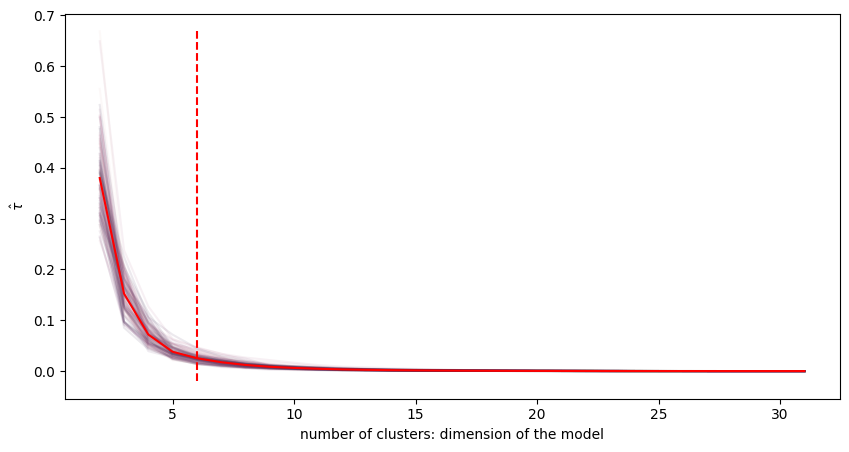

In [126]:
viz_table(tables, 6)

non-hiarchical : $y = 1 + x_1 + x_4 + x_1 x_2 + x_3 x_5 + x_2 x_3 x_4 x_5$

In [127]:
def gen_y(seq, error_var = 2):
    y = 1 + seq.x1 + seq.x2 + seq.x3 + seq.x1 * seq.x2 + seq.x1 * seq.x3 
    y += np.random.normal(scale = sqrt(error_var))
    return y

In [128]:
tables = bootstrap(gen_y)

100%|██████████| 100/100 [02:39<00:00,  1.59s/it]


In [129]:
confidence_intervals(tables, 6)

(0.012518149874958832, 0.03713609262183667, 0.02482712124839775)

In [130]:
confidence_intervals(tables, 10)

(0.0025943479511272923, 0.009938939750913495, 0.006266643851020394)

In [131]:
confidence_intervals(tables, 15)

(0.00039582291612274634, 0.0024801735019021553, 0.0014379982090124508)

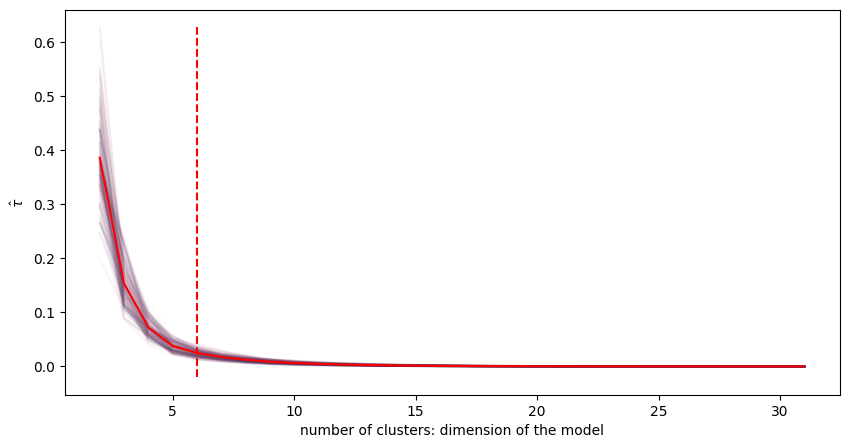

In [132]:
viz_table(tables, 6, hierarchical= False)

#### When $p*$ is 10

hiarchical : $y = 1 + x_1 + x_2 + x_3 + x_4 +  x_1 x_2 + x_1 x_3+ x_1 x_4 + x_3 x_4 + x_1 x_2 x_3 $

In [133]:
def gen_y(seq, error_var = 2):
    y = 1 + seq.x1 + seq.x2 + seq.x3 + seq.x4 + seq.x1 * seq.x2 + seq.x1 * seq.x3 + seq.x3 * seq.x4 + seq.x1 * seq.x2 *seq.x3 
    y += np.random.normal(scale = sqrt(error_var))
    return y

In [134]:
tables = bootstrap(gen_y)

  9%|▉         | 9/100 [00:14<02:23,  1.57s/it]

100%|██████████| 100/100 [02:40<00:00,  1.60s/it]


In [135]:
confidence_intervals(tables, 6)

(0.030242395209178777, 0.09462036617482399, 0.06243138069200138)

In [136]:
confidence_intervals(tables, 10)

(0.005933453328233559, 0.021313334373397653, 0.013623393850815606)

In [137]:
confidence_intervals(tables, 15)

(0.000598413138837219, 0.005149568287511544, 0.002873990713174382)

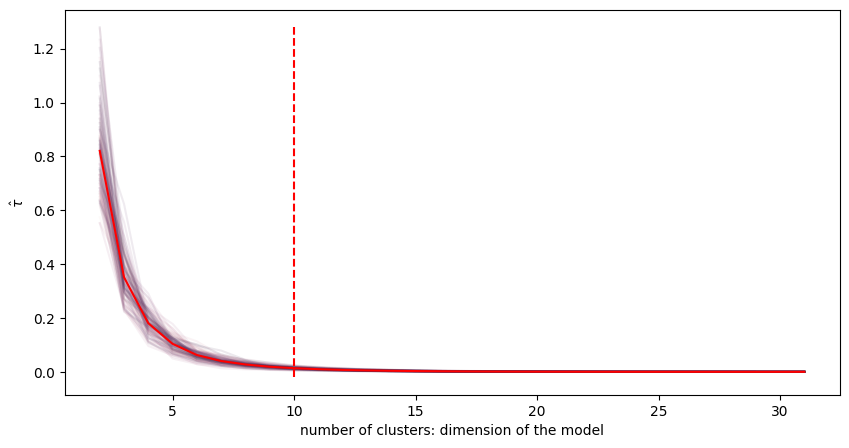

In [138]:
viz_table(tables, 10, hierarchical= True)

non-hiarchical : $y = 1 + x_1 + x_2 + x_4 + x_1 x_2 + x_2 x_4 + x_3 x_5 + x_1 x_3 x_5 + x_1x_2x_3 + x_2 x_3 x_4 x_5  $

In [139]:
def gen_y(seq, error_var = 2):
    y = 1 + seq.x1 + seq.x2 + seq.x4 + seq.x1 * seq.x2 + seq.x2 * seq.x4 + seq.x3 * seq.x5 + seq.x1 * seq.x3 *seq.x5 + seq.x2 * seq.x3 * seq.x4 * seq.x5
    y += np.random.normal(scale = sqrt(error_var))
    return y

In [140]:
tables = bootstrap(gen_y)

 21%|██        | 21/100 [00:33<02:05,  1.59s/it]

100%|██████████| 100/100 [02:41<00:00,  1.61s/it]


In [141]:
confidence_intervals(tables, 6)

(0.024149166684851512, 0.06679818469425944, 0.04547367568955547)

In [142]:
confidence_intervals(tables, 10)

(0.0038455719221299443, 0.015761720336272517, 0.00980364612920123)

In [143]:
confidence_intervals(tables, 15)

(0.0005681394918300043, 0.0036555240848366094, 0.002111831788333307)

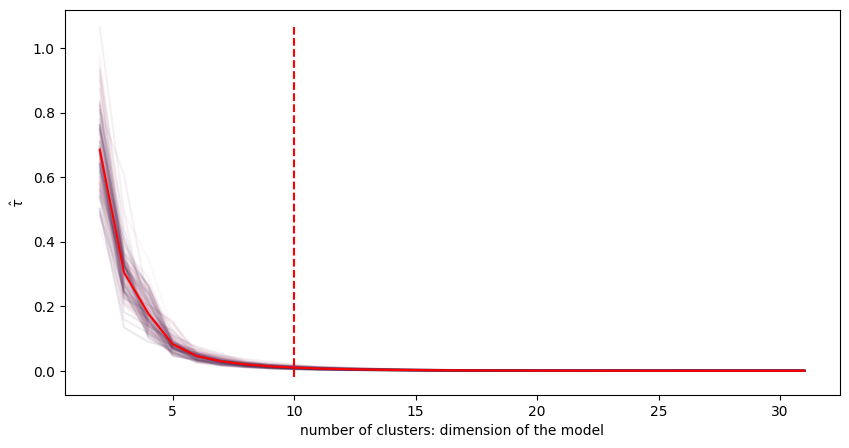

In [144]:
viz_table(tables, 10, hierarchical= False)

### When $p*$ is 15

In [41]:
from tqdm import tqdm
tables = []
for i in tqdm(range(100)):
    X = gen_X(5, 500)
    y = X.apply(gen_y, axis = 1)
    y.name = 'y'
    df = pd.concat([X, y], axis = 1)
    clustering = anova_clustering(df.iloc[:, :-1], df.y)
    tau_estimates = []
    tau_estimates_lb = []
    num_clusters = list(range(2, 2**5))
    for k in num_clusters:
        tau_est = tau(df.shape[0], 2**5, k, clustering.estimator.score, clustering.metric_after_clustering(num_clusters = k))
        tau_estimates.append(tau_est.tau_est)
        tau_estimates_lb.append(tau_est.tau_LB)
    tau_output = pd.DataFrame(zip(num_clusters, tau_estimates, tau_estimates_lb), columns = ['num_clusters','tau_estimates','tau_estimate_lower_bound'])
    tau_output['iteration'] = i
    tables.append(tau_output)

100%|██████████| 100/100 [03:36<00:00,  2.17s/it]


In [42]:
df = pd.concat(tables,axis = 0).reset_index(drop = True)

In [43]:
df_groupby = df.groupby('num_clusters').tau_estimates.mean().reset_index()

In [44]:
df_groupby.head(17)

,num_clusters,tau_estimates
0,2,2.288630
1,3,0.823294
2,4,0.524009
3,5,0.273691
4,6,0.141143
5,7,0.086357
6,8,0.060321
7,9,0.041972
8,10,0.029131
9,11,0.020619


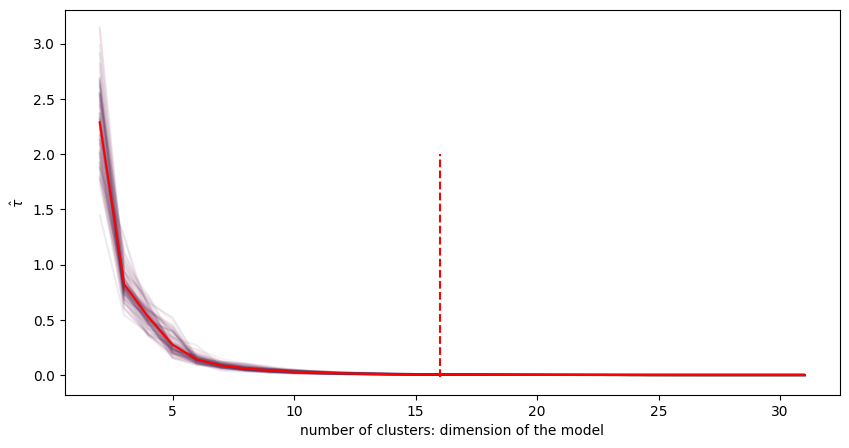

In [45]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
sns.lineplot(data = df, x = 'num_clusters', y = 'tau_estimates', hue = 'iteration', alpha = 0.1, ax = ax)
sns.lineplot(data = df_groupby, x = 'num_clusters', y = 'tau_estimates', alpha = 1, ax = ax, color = 'red')
ax.legend().remove()
ax.vlines(x = 16, ymin =-.02, ymax = 2, color = 'red', linestyles='--')
ax.set_xlabel('number of clusters: dimension of the model')
ax.set_ylabel('$\\hat{\\tau}$')
plt.show()
fig.savefig('cluster_tau.png')

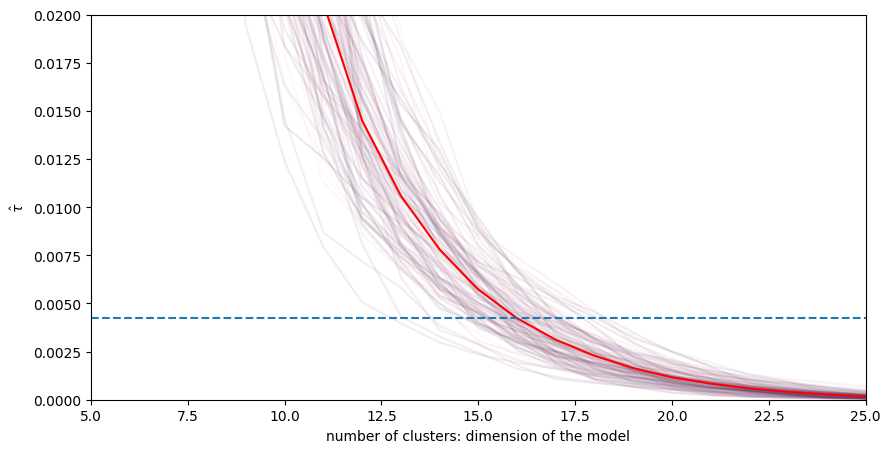

In [48]:
import seaborn as sns
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
sns.lineplot(data = df, x = 'num_clusters', y = 'tau_estimates', hue = 'iteration', alpha = 0.1, ax = ax)
sns.lineplot(data = df_groupby, x = 'num_clusters', y = 'tau_estimates', alpha = 1, ax = ax, color = 'red')
ax.set_ylim(0, 0.02)
ax.set_xlim(5, 25)
ax.legend().remove()
ax.hlines(y = 0.004233, xmin = 5, xmax = 25, linestyles='--')
ax.set_xlabel('number of clusters: dimension of the model')
ax.set_ylabel('$\\hat{\\tau}$')
plt.show()
fig.savefig('cluster_tau.png')

In [36]:
from tqdm import tqdm
beta_estimates = []
for i in tqdm(range(100)):
    X = gen_X(5, 500)
    y = X.apply(gen_y, axis = 1)
    y.name = 'y'
    df = pd.concat([X, y], axis = 1)
    clustering = anova_clustering(df.iloc[:, :-1], df.y)
    tau_estimate = 1
    num_clusters = 1
    while tau_estimate > 0.01:
        num_clusters += 1
        tau_est = tau(df.shape[0], 2**5, num_clusters, clustering.estimator.score, clustering.metric_after_clustering(num_clusters = num_clusters))
        tau_estimate = tau_est.tau_est

    beta_hat = clustering.get_projected_beta_hat(n_clusters = num_clusters)
    beta_hat = np.abs(beta_hat)
    beta_hat_rank = np.abs(beta_hat.argsort().argsort() - 2**5)
    beta_estimates.append(beta_hat_rank.reshape(1, -1))

100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


In [37]:
df = pd.DataFrame(np.concatenate(beta_estimates), columns = clustering.beta_names)

In [40]:
df.mean().sort_values()

beta1*beta2*beta3*beta4*beta5    10.11
beta1*beta2*beta3*beta4          11.66
beta2*beta3*beta4*beta5          12.04
beta1*beta2*beta3*beta5          13.28
beta3*beta4*beta5                13.99
beta1*beta2*beta4*beta5          14.05
beta1*beta3                      14.29
beta2*beta4                      14.39
beta2*beta3*beta4                14.45
beta0                            14.56
beta1*beta3*beta4                15.40
beta3*beta4                      15.65
beta1*beta4                      15.67
beta4*beta5                      15.97
beta4                            15.99
beta1*beta3*beta4*beta5          16.11
beta1                            16.21
beta3                            16.43
beta2                            16.50
beta5                            16.91
beta1*beta2*beta4                17.04
beta2*beta3*beta5                17.62
beta1*beta2*beta5                17.67
beta1*beta2*beta3                18.18
beta2*beta4*beta5                18.19
beta1*beta3*beta5        

In [41]:
from tqdm import tqdm
beta_estimates = []
for i in tqdm(range(100)):
    X = gen_X(5, 1000)
    y = X.apply(gen_y, axis = 1)
    y.name = 'y'
    df = pd.concat([X, y], axis = 1)
    clustering = anova_clustering(df.iloc[:, :-1], df.y)
    tau_estimate = 1
    num_clusters = 1
    while tau_estimate > 0.01:
        num_clusters += 1
        tau_est = tau(df.shape[0], 2**5, num_clusters, clustering.estimator.score, clustering.metric_after_clustering(num_clusters = num_clusters))
        tau_estimate = tau_est.tau_est

    beta_hat = clustering.get_projected_beta_hat(n_clusters = num_clusters)
    beta_hat = np.abs(beta_hat)
    beta_hat_rank = np.abs(beta_hat.argsort().argsort() - 2**5)
    beta_estimates.append(beta_hat_rank.reshape(1, -1))
df = pd.DataFrame(np.concatenate(beta_estimates), columns = clustering.beta_names)
df.mean().sort_values()

100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


beta3*beta4*beta5                10.73
beta1*beta3*beta4                11.04
beta0                            11.43
beta3                            11.93
beta2*beta4                      12.08
beta2*beta3*beta4                12.30
beta1*beta4                      12.32
beta4                            12.39
beta2                            12.64
beta5                            12.68
beta1*beta2*beta3*beta4          12.81
beta1                            12.85
beta1*beta3                      13.20
beta4*beta5                      13.91
beta1*beta2*beta3*beta4*beta5    13.94
beta3*beta4                      14.23
beta2*beta3*beta4*beta5          14.66
beta1*beta2*beta4*beta5          15.93
beta1*beta2*beta3*beta5          16.08
beta1*beta3*beta4*beta5          17.61
beta1*beta2*beta5                19.68
beta2*beta3*beta5                19.85
beta2*beta4*beta5                19.98
beta1*beta2*beta3                20.27
beta1*beta3*beta5                20.63
beta1*beta2*beta4        

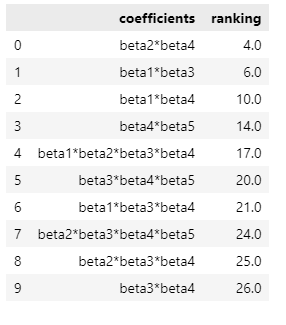

In [44]:
from tqdm import tqdm
beta_estimates = []
for i in tqdm(range(100)):
    X = gen_X(5, 2000)
    y = X.apply(gen_y, axis = 1)
    y.name = 'y'
    df = pd.concat([X, y], axis = 1)
    clustering = anova_clustering(df.iloc[:, :-1], df.y)
    tau_estimate = 1
    num_clusters = 1
    while tau_estimate > 0.01:
        num_clusters += 1
        tau_est = tau(df.shape[0], 2**5, num_clusters, clustering.estimator.score, clustering.metric_after_clustering(num_clusters = num_clusters))
        tau_estimate = tau_est.tau_est

    beta_hat = clustering.get_projected_beta_hat(n_clusters = num_clusters)
    beta_hat = np.abs(beta_hat)
    beta_hat_rank = np.abs(beta_hat.argsort().argsort() - 2**5)
    beta_estimates.append(beta_hat_rank.reshape(1, -1))
df = pd.DataFrame(np.concatenate(beta_estimates), columns = clustering.beta_names)
df.mean().sort_values()

100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


beta2                             8.90
beta3                             9.36
beta1                             9.40
beta1*beta4                       9.50
beta2*beta3*beta4                 9.51
beta3*beta4*beta5                 9.83
beta2*beta4                      10.12
beta0                            10.14
beta1*beta3                      10.15
beta1*beta2*beta3*beta4          10.40
beta5                            10.41
beta4*beta5                      10.43
beta3*beta4                      10.62
beta4                            10.62
beta1*beta3*beta4                10.80
beta2*beta3*beta4*beta5          11.85
beta1*beta2*beta3*beta4*beta5    15.59
beta1*beta2*beta3*beta5          18.94
beta1*beta3*beta4*beta5          19.30
beta1*beta2*beta4*beta5          19.34
beta2*beta3*beta5                21.73
beta1*beta2*beta5                22.69
beta1*beta3*beta5                22.92
beta1*beta2*beta3                23.34
beta1*beta4*beta5                23.62
beta1*beta2*beta4        